## Computer Vision

# PART A - 20 Marks

- **DOMAIN:**  Entertainment <br/><br/>
- **CONTEXT:**  Company  X  owns  a  movie  application  and  repository  which  caters  movie  streaming  to  millions  of  users  who  on  subscription  basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and  clicks  on  cast  information  button,  the  app  will  show  details  of  the  actor  in  the  scene.  Company  has  an  in-house  computer  vision  and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. <br/><br/>
- **DATA DESCRIPTION:** The dataset comprises of images and its mask for corresponding human face.<br/><br/>
- **PROJECT  OBJECTIVE:**  To build a face detection system.  

## Steps and tasks: [ Total Score: 20 Marks]

### 1. Import and Understand the data [7 Marks]
<ol style="list-style-type: upper-alpha;">
    <li> Import and read ‘images.npy’. [1 Marks] </li>
    <li> Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks] <br/>
    <em style='font-size:13px'> Imp Note: Replace all the pixels within masked area with 1. <br/>
    Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1]. </em></li>
    <li> Split the data into train and test[400:9]. [1 Marks] </li>
    <li> Select random image from the train data and display original image and masked image. [2 Marks] </li>
</ol>

##### Q. 1.A. Import and read ‘images.npy’.

In [1]:

#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf



In [2]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Load images and labels from the .npy file

if RunningInCOLAB:
    file_path = '/content/drive/MyDrive/Tuhin/AI-ML Course - UT Austin/Projects/8-Computer Vision/images.npy' # Google Drive path
else:
    file_path = 'images.npy' # Local path
data = np.load(file_path, allow_pickle=True)


##### Q. 1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [4]:
#First standardize the image shape

#We use MobileNetV2 for transfer learning. This model expects the input image to be of shape (224,224,3)
image_height = 224
image_width  = 224
channels     = 3

#Create X and Y sets
X = np.zeros((int(data.shape[0]),image_height, image_width, 3)) #Contains the original image (reshaped)
Y = np.zeros((int(data.shape[0]), image_height, image_width)) #Contains masks corresponding to the face co-ordinates

#Now populate the X and Y sets
no_of_images = len(data)
#Loop through the data to extract the face region and replace the pixel values with 1
for i in range(no_of_images):
    img = data[i][0]  #Load original image array
    img = cv2.resize(img, dsize=(image_height, image_width), interpolation=cv2.INTER_CUBIC) #Resize the image to 224x224

    #We will use 3 channels only, so let's try to discard the alpha channel if it exists
    #But if any image has only 1 channel (grayscale), then we will convert it to 3 channels
    try:
        #Discard the alpha channel if it exists
        img = img[:,:,:3]
    except:
        #Convert the grayscale image to color so that the number of channels are standardized to 3
        print(f"Found image {i} as Grayscale image, changing it 3 channel color image.")
        # convert the grayscale image to color so that the number of channels are standardized to 3
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        continue
    #Now populate the X and Y sets
    X[i] = np.array(img, dtype=np.float32)
    for mask in data[i][1]:
        if 'Face' in mask['label']:
            x1=int(mask['points'][0]['x'] * image_width)
            y1=int(mask['points'][0]['y'] * image_height)
            x2=int(mask['points'][1]['x'] * image_width)
            y2=int(mask['points'][1]['y'] * image_height)
            Y[i][y1:y2, x1:x2] = 1 # set all pixels within the mask co-ordinates to 1.

print(f"X and Y populated, shape of X is '{X.shape}' and the shape of Y is '{Y.shape}' ")

Found image 272 as Grayscale image, changing it 3 channel color image.
X and Y populated, shape of X is '(409, 224, 224, 3)' and the shape of Y is '(409, 224, 224)' 


##### Q. 1.C. Split the data into train and test[400:9].

In [5]:
#Split X and Y in train in test sets with 400:9 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.0225, random_state=42)


##### Q. 1.D. Select random image from the train data and display original image and masked image.

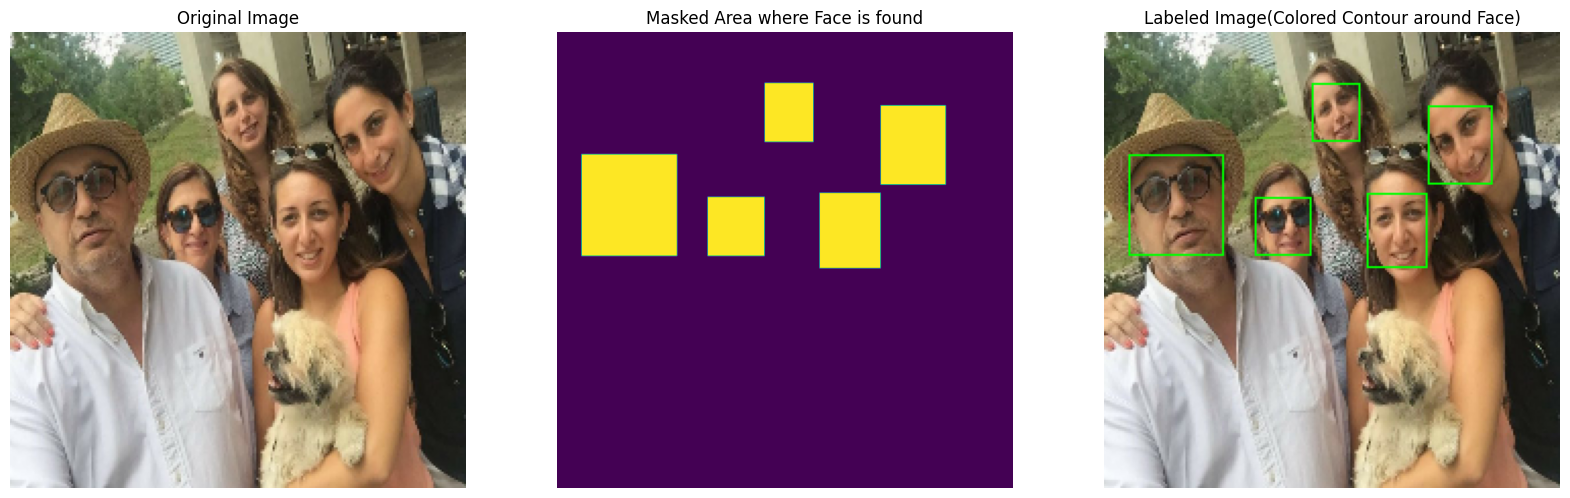

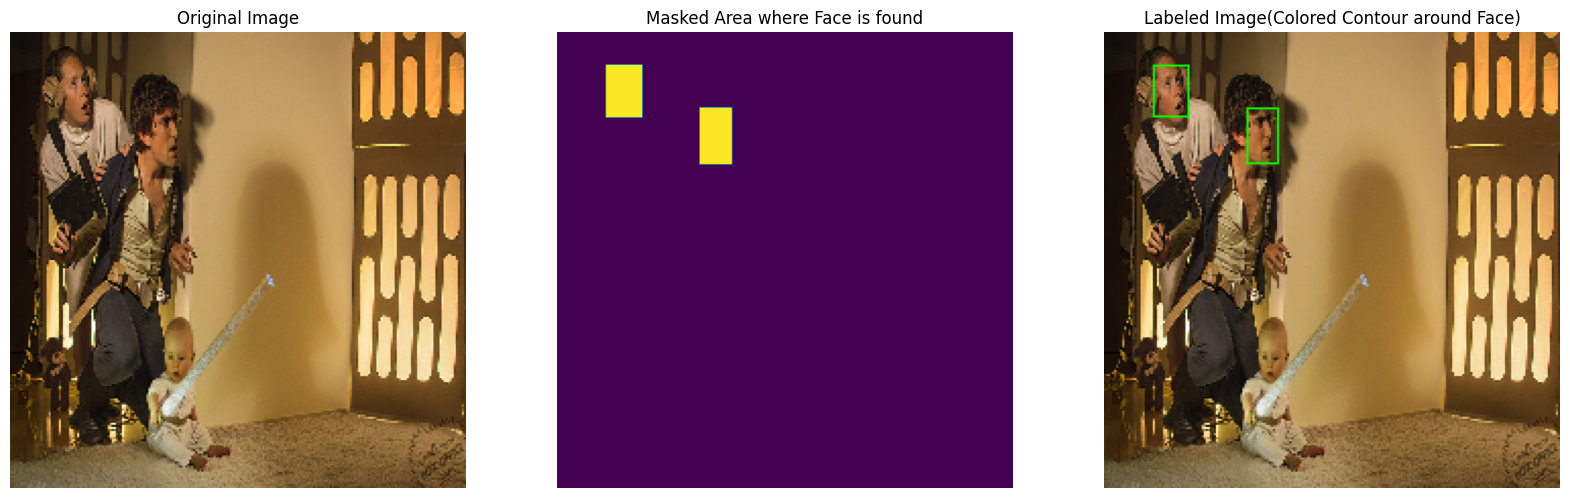

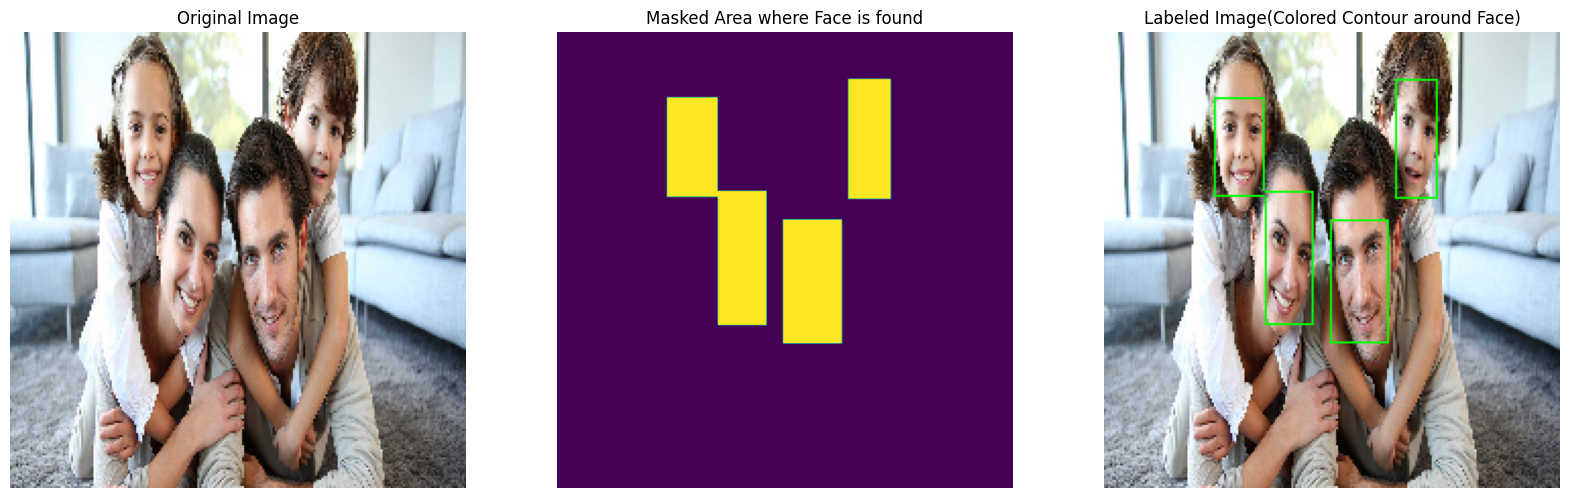

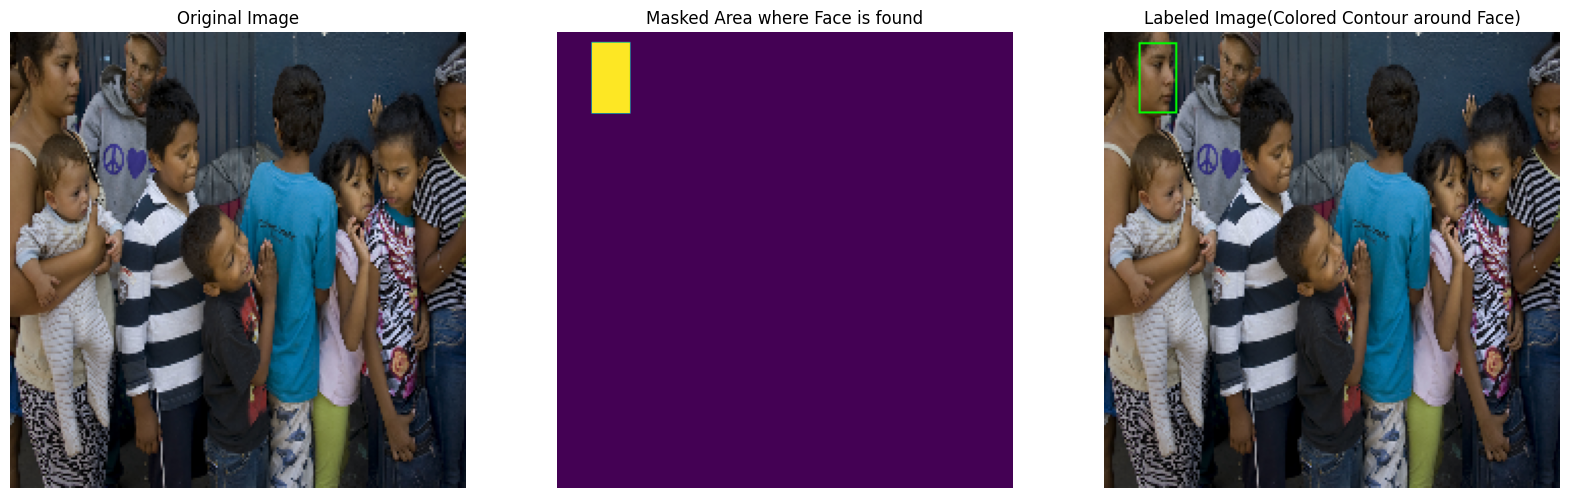

In [6]:
def show_image(index):
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    axs[0].imshow((X_train[index]/255).astype(np.float32))
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow(Y_train[index])
    axs[1].set_title("Masked Area where Face is found")
    axs[1].axis('off')
    #Draw a countour around detected face in test_image from the predicted masked area
    contours, _ = cv2.findContours(Y_train[index].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contoured_image = np.copy(X_train[index])
    cv2.drawContours(contoured_image, contours, -1, (0, 255, 0), 1)
    axs[2].imshow((contoured_image/255).astype(np.float32))
    axs[2].set_title("Labeled Image(Colored Contour around Face)")
    axs[2].axis('off')
    plt.show()

#Select 4 random images from train data and display original image and masked image
indexes = np.random.randint(0, X_train.shape[0], size=4)
for index in indexes:
    show_image(index)

### 2. Model building [11 Marks]
<ol style="list-style-type: upper-alpha;">
    <li> Design a face mask detection model. [4 Marks] <br/>
    <em style='font-size:13px'> Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers. <br/>
    Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture. </em></li>
    </li>
    <li> Design your own Dice Coefficient and Loss function. [2 Marks] <br/>
    </li>
    <li> Train and tune the model as required. [3 Marks]  </li>
    <li> Evaluate and share insights on performance of the model. [2 Marks] </li>
</ol>

##### Q. 2.A. Design a face mask detection model

In [7]:

# Set some hyper parameters
epochs = 30 #@param {type:"integer"}
batch_size = 8 #@param {type:"integer"}
learning_rate = 1e-4 #@param {type:"number"}


In [8]:

# Define the model
def model():

    #Define the model

    #We will use MobileNetV2 for transfer learning. This model expects the input image to be of shape (224,224,3)
    #Input Image Layer
    input = tf.keras.layers.Input([image_height, image_width, 3], dtype = tf.uint8, name="original_input_image")

    #Preprocess the input image
    x = tf.cast(input, tf.float32)

    input_image_name = x.name.split('/')[0]

    x = tf.keras.applications.mobilenet.preprocess_input(x)

    #Load the MobileNetV2 model with the preprocessed input images
    encoder = tf.keras.applications.MobileNetV2(input_tensor=x, input_shape=(image_height,image_width, 3), weights="imagenet", include_top=False, alpha=0.35)

    encoder_output = encoder.get_layer("block_13_expand_relu").output

    skip_connection_names = [input_image_name, "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]

    #Decoder
    f = [16, 32, 48, 64]
    x = encoder_output

    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, x_skip])

        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)


    x = tf.keras.layers.Conv2D(1, (1, 1), padding="same")(x)
    output = tf.keras.layers.Activation("sigmoid")(x)


    model = tf.keras.models.Model(inputs=[input], outputs=[output])
    return model


In [9]:
#Create the model
model = model()
model.summary()

2019640/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 original_input_image (Inpu  [(None, 224, 224, 3)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.cast (TFOpLambda)        (None, 224, 224, 3)          0         ['original_input_image[0][0]']
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['tf.cast[0][0]']             
 a)                                                                                               
                               

In [10]:
#Show the model architecture
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_activations=True)

Output hidden; open in https://colab.research.google.com to view.

##### Q. 2.B. Design your own Dice Coefficient and Loss function.

In [11]:
smooth = 1e-15 #@param
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

##### Q. 2.C. Train and tune the model as required.

In [12]:
opt = tf.keras.optimizers.Nadam(learning_rate)
metrics = [dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [13]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [17]:
train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    valid_steps += 1


model_run=model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - 4s 87ms/step - loss: 0.3208 - dice_coef: 0.6784 - recall: 0.9460 - precision: 0.8235 - val_loss: 0.4812 - val_dice_coef: 0.5188 - val_recall: 0.5622 - val_precision: 0.7966 - lr: 1.0000e-05
Epoch 2/30
50/50 [==============================] - 4s 84ms/step - loss: 0.3232 - dice_coef: 0.6769 - recall: 0.9425 - precision: 0.8188 - val_loss: 0.5012 - val_dice_coef: 0.4988 - val_recall: 0.5213 - val_precision: 0.8156 - lr: 1.0000e-05
Epoch 3/30
50/50 [==============================] - 4s 89ms/step - loss: 0.3257 - dice_coef: 0.6743 - recall: 0.9455 - precision: 0.8175 - val_loss: 0.4853 - val_dice_coef: 0.5147 - val_recall: 0.5539 - val_precision: 0.7941 - lr: 1.0000e-05
Epoch 4/30
50/50 [==============================] - 4s 86ms/step - loss: 0.3126 - dice_coef: 0.6871 - recall: 0.9531 - precision: 0.8203 - val_loss: 0.4860 - val_dice_coef: 0.5140 - val_recall: 0.5501 - val_precision: 0.7927 - lr: 1.0000e-05
Epoch 5/30
50/50 [==============

##### Q. 2.D. Evaluate and share insights on performance of the model.

2/2 [==============================] - 0s 30ms/step - loss: 0.4733 - dice_coef: 0.5267 - recall: 0.5724 - precision: 0.7563


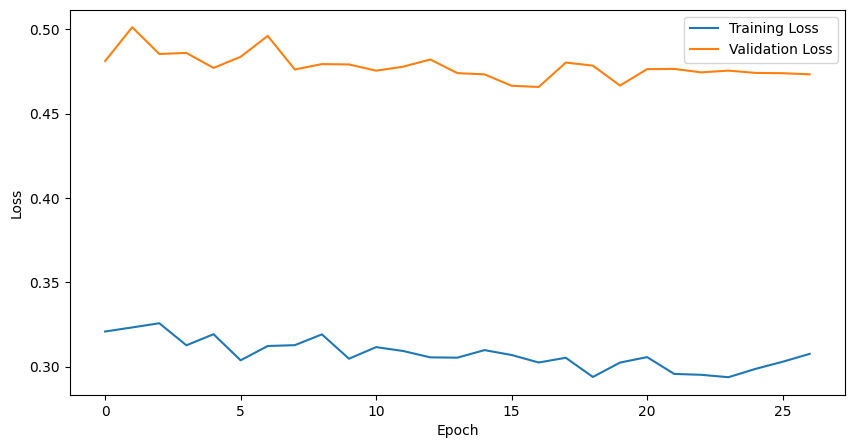

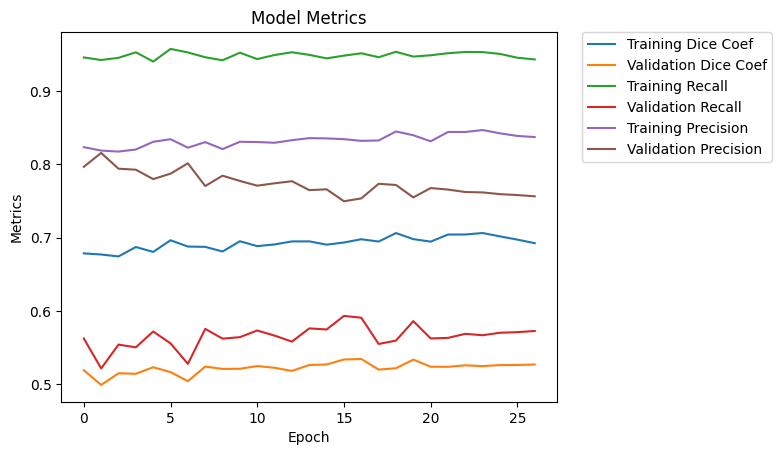

In [24]:
test_steps = (len(X_test)//batch_size)
if len(X_test) % batch_size != 0:
    test_steps += 1

model.evaluate(X_test, Y_test, steps=test_steps)

#Show the training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(model_run.history['loss'], label='Training Loss')
plt.plot(model_run.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Show the training vs validation dice coef over the 30 epochs
plt.plot(model_run.history['dice_coef'], label='Training Dice Coef')
plt.plot(model_run.history['val_dice_coef'], label='Validation Dice Coef')
plt.plot(model_run.history['recall'], label='Training Recall')
plt.plot(model_run.history['val_recall'], label='Validation Recall')
plt.plot(model_run.history['precision'], label='Training Precision')
plt.plot(model_run.history['val_precision'], label='Validation Precision')
plt.title('Model Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Insight of the performance of the model
- The model has been trained on 400 images and tested on 9 images.
- The model has been trained on 30 epochs with batch size of 8.
- The model has been trained with learning rate of 1e-4 and optimizer Nadam.
- The model has been trained with callbacks ReduceLROnPlateau and EarlyStopping.
- The model has been trained with metrics dice_coef, Recall and Precision.
- The model has been trained with loss function dice_loss.
- The model has been trained with 4 skip connections.
- The model has been trained with 4 up sampling layers.
- The model has been trained with 4 concatenate layers.
- The model has been trained with 4 convolution layers.
- The model has been trained with 4 batch normalization layers.
- The model has been trained with 4 activation layers.
- The model has been trained with 1 sigmoid layer.
- The model has been trained with 1 flatten layer.
- The model has been trained with 1 input layer.
- The model has been trained with 1 output layer.
- The model has been trained with 1 MobileNetV2 layer.
- The model has been trained with 1 Nadam optimizer.
- The model has been trained with 1 input tensor.
- The model has been trained with 1 output tensor.

##### Q. 3 Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

1/1 [==============================] - 0s 40ms/step


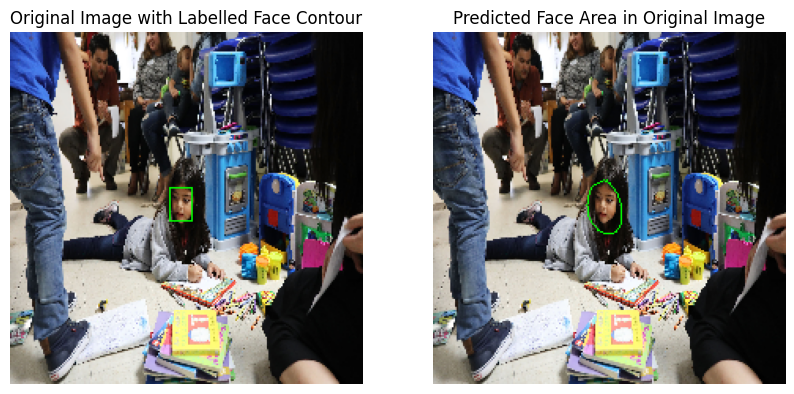

In [ ]:
def show_original_vs_predicted_face_area(i):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    test_image = np.copy(X_test[i])
    #Draw a countour around detected face in test_image from the predicted masked area
    contours, _ = cv2.findContours(Y_test[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(test_image, contours, -1, (0, 255, 0), 1)

    axs[0].imshow((test_image/255).astype(np.float32))
    axs[0].set_title("Original Image with Labelled Face Contour")
    axs[0].axis('off')

    test_image = np.copy(X_test[i])

    Y_pred = model.predict(np.array([test_image]))
    pred_mask = cv2.resize((1.0*(Y_pred[0] > 0.5)), (image_width,image_height))

    #Draw a countour around detected face in test_image from the predicted masked area
    contours, _ = cv2.findContours(pred_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(test_image, contours, -1, (0, 255, 0), 1)

    axs[1].imshow((test_image/255).astype(np.float32))
    axs[1].set_title("Predicted Face Area in Original Image")
    axs[1].axis('off')

    plt.show()

#for i in range(9):
#    show_original_vs_predicted_face_area(i)

#Show third image
show_original_vs_predicted_face_area(3)
